$$
\frac{d}{dt} \rho^s(t) = - \iota [H_s, \rho^s] + \gamma_0 (N+1) \left( \sigma_- \rho^s(t) \sigma_+ - \frac{1}{2} \sigma_+ \sigma_- \rho^s(t) - \frac{1}{2} \rho^s(t) \sigma_+ \sigma_- \right)  + \gamma_0 N \left( \sigma_+ \rho^s(t) \sigma_- - \frac{1}{2} \sigma_- \sigma_+ \rho^s(t) - \frac{1}{2} \rho^s(t) \sigma_- \sigma_+ \right) - \gamma_0 M \sigma_+ \rho^s(t) \sigma_+ - \gamma_0 M^* \sigma_- \rho^s(t) \sigma_-
$$

where $ H_s = \frac{\hbar \omega}{2} \sigma_z $

Excluding $ \gamma_0 M \sigma_+ \rho^s(t) \sigma_+ - \gamma_0 M^* \sigma_- \rho^s(t) \sigma_- $ then the master equation will be
$$
\frac{d}{dt} \rho^s(t) = - \iota[H_s, \rho^s] + \gamma_0 (N+1) \left( \sigma_- \rho^s(t) \sigma_+ - \frac{1}{2} \sigma_+ \sigma_- \rho^s(t) - \frac{1}{2} \rho^s(t) \sigma_+ \sigma_- \right)  + \gamma_0 N \left( \sigma_+ \rho^s(t) \sigma_- - \frac{1}{2} \sigma_- \sigma_+ \rho^s(t) - \frac{1}{2} \rho^s(t) \sigma_- \sigma_+ \right) 
$$

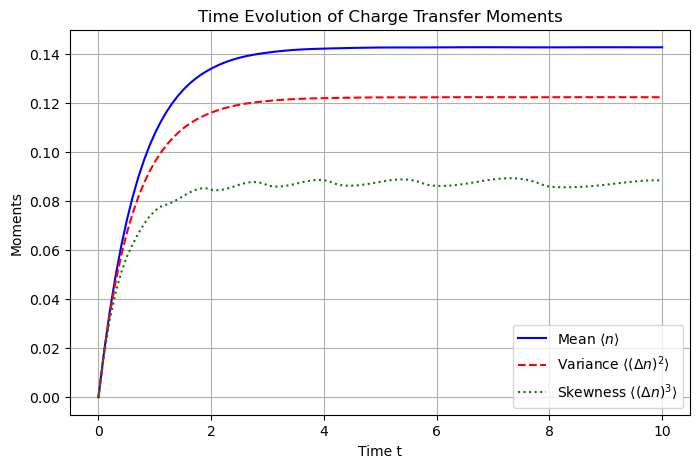

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
chi_values = np.linspace(-np.pi, np.pi, 100)
gamma_t = 1.0
Nb = 0.2
Omega = 1.0

# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Hamiltonian H
H = (Omega / 2) * sigma_z

# Define the Lindbladian RHS with counting field chi
def lindblad_rhs_chi(t, rho_flat, counting_field):
    """Compute d(rho)/dt for the tilted master equation."""
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # Hamiltonian part
    commutator = -1j * (H @ rho - rho @ H)

    # Dissipative terms
    L1 = np.sqrt(gamma_t * (Nb + 1)) * sigma_minus
    L2 = np.sqrt(gamma_t * Nb) * sigma_plus

    # Tilted dissipators
    D1 = np.exp(-1j * counting_field) * (L1 @ rho @ L1.conj().T) - 0.5 * (L1.conj().T @ L1 @ rho + rho @ L1.conj().T @ L1)
    D2 = np.exp(1j * counting_field) * (L2 @ rho @ L2.conj().T) - 0.5 * (L2.conj().T @ L2 @ rho + rho @ L2.conj().T @ L2)

    d_rho = commutator + D1 + D2

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])

# Initial state: pure |1⟩ state
rho0 = np.array([[0, 0], [0, 1]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])

# Time range
t_final = 10
t_eval = np.linspace(0, t_final, 100)

# Compute P(chi, t) for different chi values at each time step
P_chi_t = np.zeros((len(t_eval), len(chi_values)), dtype=complex)

for j, chi_val in enumerate(chi_values):
    sol_chi = solve_ivp(
        lindblad_rhs_chi, (0, t_final), rho0_flat,
        t_eval=t_eval, args=(chi_val,), vectorized=True, method='RK45'
    )

    num_t_points = len(sol_chi.t)
    rho_chi_solutions = (sol_chi.y[:4, :num_t_points].T + 1j * sol_chi.y[4:, :num_t_points].T).reshape(num_t_points, 2, 2)

    P_chi_t[:num_t_points, j] = np.array([np.trace(rho) for rho in rho_chi_solutions])

# Compute the cumulant generating function S(chi, t) = log P(chi, t)
S_chi_t = np.log(np.maximum(P_chi_t, 1e-10))  # Avoid log(0) errors

# Compute moments by differentiation at each time step
dS_dchi = np.gradient(S_chi_t, 1j * chi_values, axis=1)  # First derivative -> Mean
d2S_dchi2 = np.gradient(dS_dchi, 1j * chi_values, axis=1)  # Second derivative -> Variance
d3S_dchi3 = np.gradient(d2S_dchi2, 1j * chi_values, axis=1)  # Third derivative -> Skewness

# Find index for chi = 0
chi_0_index = np.argmin(np.abs(chi_values))

# Extract time evolution of moments
mean_n_t = np.real(dS_dchi[:, chi_0_index])
variance_n_t = np.real(d2S_dchi2[:, chi_0_index])
skewness_n_t = np.real(d3S_dchi3[:, chi_0_index])

# Plot time evolution of moments
plt.figure(figsize=(8, 5))
plt.plot(t_eval, mean_n_t, label=r"Mean $\langle n \rangle$", color="blue")
plt.plot(t_eval, variance_n_t, label=r"Variance $\langle (\Delta n)^2 \rangle$", color="red", linestyle="dashed")
plt.plot(t_eval, skewness_n_t, label=r"Skewness $\langle (\Delta n)^3 \rangle$", color="green", linestyle="dotted")
plt.xlabel("Time t")
plt.ylabel("Moments")
plt.legend()
plt.title("Time Evolution of Charge Transfer Moments")
plt.grid()
plt.show()

$$
\frac{d}{dt} \rho^s(t) = - \iota [H_s, \rho^s] + \gamma_0 (N+1) \left( \sigma_- \rho^s(t) \sigma_+ - \frac{1}{2} \sigma_+ \sigma_- \rho^s(t) - \frac{1}{2} \rho^s(t) \sigma_+ \sigma_- \right)  + \gamma_0 N \left( \sigma_+ \rho^s(t) \sigma_- - \frac{1}{2} \sigma_- \sigma_+ \rho^s(t) - \frac{1}{2} \rho^s(t) \sigma_- \sigma_+ \right) - \gamma_0 M \sigma_+ \rho^s(t) \sigma_+ - \gamma_0 M^* \sigma_- \rho^s(t) \sigma_-
$$

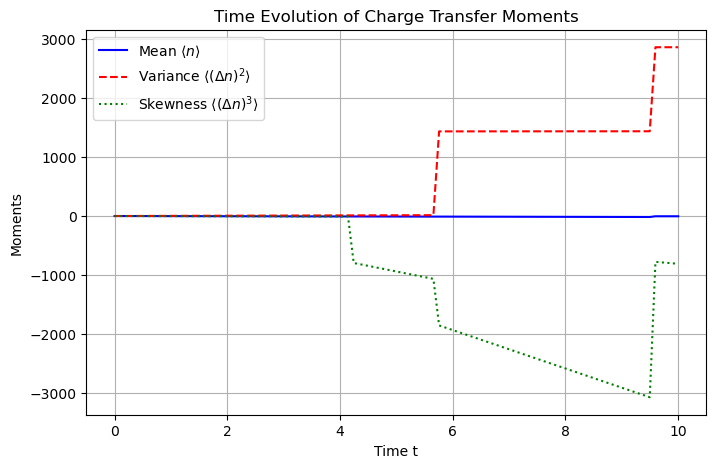

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
chi_values = np.linspace(-np.pi, np.pi, 100)
gamma_t = 1.0
Nb = 0.2
Omega = 1.0

# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Hamiltonian H
H = (Omega / 2) * sigma_z

# Define the Lindbladian RHS with counting field chi
def lindblad_rhs_chi(t, rho_flat, counting_field, r=1, phi=1):
    """Compute d(rho)/dt for the tilted master equation."""
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # Hamiltonian part
    commutator = -1j * (H @ rho - rho @ H)
    R = np.cosh(r)*sigma_minus + np.exp(1j*phi)*np.sinh(r)*sigma_plus
    # R_dag = np.cosh(r)*sigma_plus + np.exp(-1j*phi)*np.sinh(r)*sigma_minus
    # Dissipative terms
    R1 = np.sqrt(gamma_t * ((Nb + 1)/2)) * R
    R2 = np.sqrt(gamma_t * (Nb/2)) * R.conj().T

    # Tilted dissipators
    D1 = 2*np.exp(-1j * counting_field) * (R1 @ rho @ R1.conj().T) - (R1.conj().T @ R1 @ rho + rho @ R1.conj().T @ R1)
    D2 = 2*np.exp(1j * counting_field) * (R2 @ rho @ R2.conj().T) - (R2.conj().T @ R2 @ rho + rho @ R2.conj().T @ R2)

    d_rho = commutator + D1 + D2

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])

# Initial state: pure |1⟩ state
rho0 = np.array([[0, 0], [0, 1]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])

# Time range
t_final = 10
t_eval = np.linspace(0, t_final, 100)

# Compute P(chi, t) for different chi values at each time step
P_chi_t = np.zeros((len(t_eval), len(chi_values)), dtype=complex)

for j, chi_val in enumerate(chi_values):
    sol_chi = solve_ivp(
        lindblad_rhs_chi, (0, t_final), rho0_flat,
        t_eval=t_eval, args=(chi_val,), vectorized=True, method='RK45'
    )

    num_t_points = len(sol_chi.t)
    rho_chi_solutions = (sol_chi.y[:4, :num_t_points].T + 1j * sol_chi.y[4:, :num_t_points].T).reshape(num_t_points, 2, 2)

    P_chi_t[:num_t_points, j] = np.array([np.trace(rho) for rho in rho_chi_solutions])

# Compute the cumulant generating function S(chi, t) = log P(chi, t)
S_chi_t = np.log(np.maximum(P_chi_t, 1e-10))  # Avoid log(0) errors

# Compute moments by differentiation at each time step
dS_dchi = np.gradient(S_chi_t, 1j * chi_values, axis=1)  # First derivative -> Mean
d2S_dchi2 = np.gradient(dS_dchi, 1j * chi_values, axis=1)  # Second derivative -> Variance
d3S_dchi3 = np.gradient(d2S_dchi2, 1j * chi_values, axis=1)  # Third derivative -> Skewness

# Find index for chi = 0
chi_0_index = np.argmin(np.abs(chi_values))

# Extract time evolution of moments
mean_n_t = np.real(dS_dchi[:, chi_0_index])
variance_n_t = np.real(d2S_dchi2[:, chi_0_index])
skewness_n_t = np.real(d3S_dchi3[:, chi_0_index])

# Plot time evolution of moments
plt.figure(figsize=(8, 5))
plt.plot(t_eval, mean_n_t, label=r"Mean $\langle n \rangle$", color="blue")
plt.plot(t_eval, variance_n_t, label=r"Variance $\langle (\Delta n)^2 \rangle$", color="red", linestyle="dashed")
plt.plot(t_eval, skewness_n_t, label=r"Skewness $\langle (\Delta n)^3 \rangle$", color="green", linestyle="dotted")
# plt.plot(t_eval, variance_n_t/mean_n_t, label=r"Skewness $\langle (\Delta n)^3 \rangle$", color="black", linestyle="dotted")
plt.xlabel("Time t")
plt.ylabel("Moments")
plt.legend()
plt.title("Time Evolution of Charge Transfer Moments")
plt.grid()
plt.show()

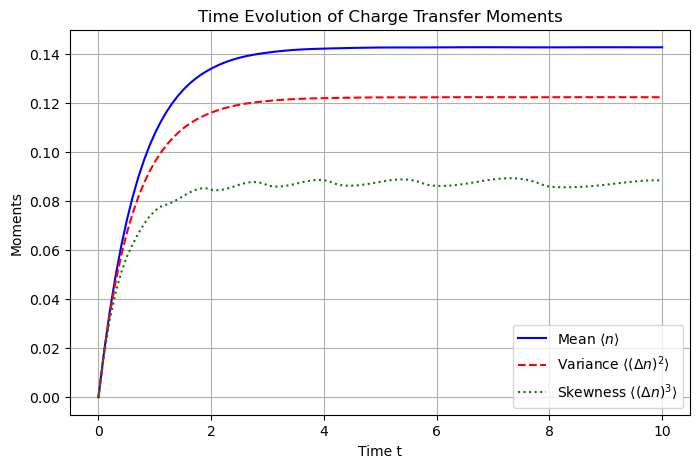

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
chi_values = np.linspace(-np.pi, np.pi, 100)
gamma_t = 1.0
Nb = 0.2
Omega = 1.0

# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Hamiltonian H
H = (Omega / 2) * sigma_z

# Define the Lindbladian RHS with counting field chi
def lindblad_rhs_chi(t, rho_flat, counting_field, r=0, phi=0):
    """Compute d(rho)/dt for the tilted master equation."""
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # Hamiltonian part
    commutator = -1j * (H @ rho - rho @ H)
    R = np.cosh(r)*sigma_minus + np.exp(1j*phi)*np.sinh(r)*sigma_plus
    # R_dag = np.cosh(r)*sigma_plus + np.exp(-1j*phi)*np.sinh(r)*sigma_minus
    # Dissipative terms
    R1 = np.sqrt(gamma_t * ((Nb + 1)/2)) * R
    R2 = np.sqrt(gamma_t * (Nb/2)) * R.conj().T

    # Tilted dissipators
    D1 = 2*np.exp(-1j * counting_field) * (R1 @ rho @ R1.conj().T) - (R1.conj().T @ R1 @ rho + rho @ R1.conj().T @ R1)
    D2 = 2*np.exp(1j * counting_field) * (R2 @ rho @ R2.conj().T) - (R2.conj().T @ R2 @ rho + rho @ R2.conj().T @ R2)

    d_rho = commutator + D1 + D2

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])

# Initial state: pure |1⟩ state
rho0 = np.array([[0, 0], [0, 1]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])

# Time range
t_final = 10
t_eval = np.linspace(0, t_final, 100)

# Compute P(chi, t) for different chi values at each time step
P_chi_t = np.zeros((len(t_eval), len(chi_values)), dtype=complex)

for j, chi_val in enumerate(chi_values):
    sol_chi = solve_ivp(
        lindblad_rhs_chi, (0, t_final), rho0_flat,
        t_eval=t_eval, args=(chi_val,), vectorized=True, method='RK45'
    )

    num_t_points = len(sol_chi.t)
    rho_chi_solutions = (sol_chi.y[:4, :num_t_points].T + 1j * sol_chi.y[4:, :num_t_points].T).reshape(num_t_points, 2, 2)

    P_chi_t[:num_t_points, j] = np.array([np.trace(rho) for rho in rho_chi_solutions])

# Compute the cumulant generating function S(chi, t) = log P(chi, t)
S_chi_t = np.log(np.maximum(P_chi_t, 1e-10))  # Avoid log(0) errors

# Compute moments by differentiation at each time step
dS_dchi = np.gradient(S_chi_t, 1j * chi_values, axis=1)  # First derivative -> Mean
d2S_dchi2 = np.gradient(dS_dchi, 1j * chi_values, axis=1)  # Second derivative -> Variance
d3S_dchi3 = np.gradient(d2S_dchi2, 1j * chi_values, axis=1)  # Third derivative -> Skewness

# Find index for chi = 0
chi_0_index = np.argmin(np.abs(chi_values))

# Extract time evolution of moments
mean_n_t = np.real(dS_dchi[:, chi_0_index])
variance_n_t = np.real(d2S_dchi2[:, chi_0_index])
skewness_n_t = np.real(d3S_dchi3[:, chi_0_index])

# Plot time evolution of moments
plt.figure(figsize=(8, 5))
plt.plot(t_eval, mean_n_t, label=r"Mean $\langle n \rangle$", color="blue")
plt.plot(t_eval, variance_n_t, label=r"Variance $\langle (\Delta n)^2 \rangle$", color="red", linestyle="dashed")
plt.plot(t_eval, skewness_n_t, label=r"Skewness $\langle (\Delta n)^3 \rangle$", color="green", linestyle="dotted")
plt.xlabel("Time t")
plt.ylabel("Moments")
plt.legend()
plt.title("Time Evolution of Charge Transfer Moments")
plt.grid()
plt.show()

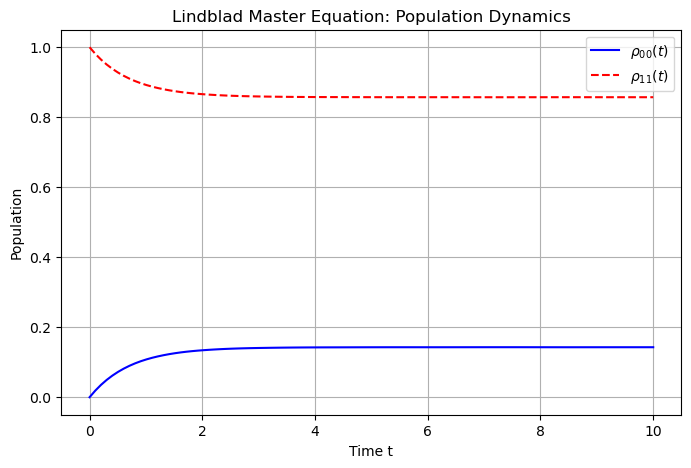

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
gamma_t = 1.0  # Dissipation rate
Nb = 0.2  # Mean bath occupation
Omega = 1.0  # Rabi frequency
Delta = 1.0  # Detuning

# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Hamiltonian H
H = (Omega / 2) * sigma_z

# Define the Lindbladian RHS with counting field chi
def lindblad_rhs(t, rho_flat):
    """Compute d(rho)/dt for the tilted master equation."""
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # Hamiltonian part
    commutator = -1j * (H @ rho - rho @ H)

    # Dissipative terms
    L1 = np.sqrt(gamma_t * (Nb + 1)) * sigma_minus  # Emission process
    L2 = np.sqrt(gamma_t * Nb) * sigma_plus  # Absorption process

    # Tilted dissipators
    D1 = (L1 @ rho @ L1.conj().T) - 0.5 * (L1.conj().T @ L1 @ rho + rho @ L1.conj().T @ L1)
    D2 = (L2 @ rho @ L2.conj().T) - 0.5 * (L2.conj().T @ L2 @ rho + rho @ L2.conj().T @ L2)

    d_rho = commutator + D1 + D2

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])


# Initial density matrix
rho0 = np.array([[0, 0], [0, 1]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])  # Flatten for solve_ivp

# Time range
t_span = (0, 10)
t_eval = np.linspace(*t_span, 100)

sol = solve_ivp(lindblad_rhs, t_span, rho0_flat, t_eval=t_eval, vectorized=True)

# Reconstruct the density matrix at each time step
rho_solutions = (sol.y[:4].T + 1j * sol.y[4:].T).reshape(-1, 2, 2)

plt.figure(figsize=(8, 5))
plt.plot(sol.t, rho_solutions[:, 0, 0].real, label=r"$\rho_{00}(t)$", color="blue")
plt.plot(sol.t, rho_solutions[:, 1, 1].real, label=r"$\rho_{11}(t)$", color="red", linestyle="dashed")
plt.xlabel("Time t")
plt.ylabel("Population")
plt.legend()
plt.title("Lindblad Master Equation: Population Dynamics")
plt.grid()
plt.show()

### Here master equation is
$$
\frac{d}{dt} \rho^s(t) = - \iota[H_s, \rho^s] + \gamma_0 (N+1) \left( \sigma_- \rho^s(t) \sigma_+ 
- \frac{1}{2} \sigma_+ \sigma_- \rho^s(t) 
- \frac{1}{2} \rho^s(t) \sigma_+ \sigma_- \right)  
+ \gamma_0 N \left( \sigma_+ \rho^s(t) \sigma_- 
- \frac{1}{2} \sigma_- \sigma_+ \rho^s(t) 
- \frac{1}{2} \rho^s(t) \sigma_- \sigma_+ \right) 
$$
with $H_s$ being $\Omega \sigma_x$

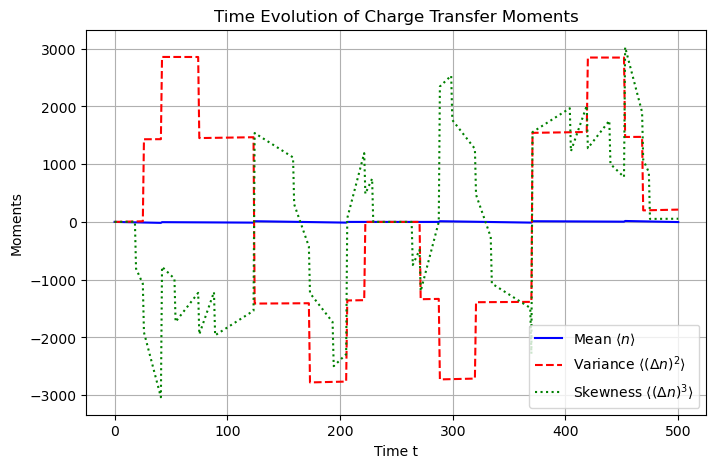

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
chi_values = np.linspace(-np.pi, np.pi, 100)  # Range of counting fields
gamma_t = 1.0  # Dissipation rate
Nb = 0.2  # Mean bath occupation
Omega = 1.0  # Rabi frequency
Delta = 0.0  # Detuning

# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Hamiltonian H
H = (Delta / 2) * sigma_z + Omega * sigma_x

# Define the Lindbladian RHS with counting field chi
def lindblad_rhs_chi(t, rho_flat, counting_field):
    """Compute d(rho)/dt for the tilted master equation."""
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # Hamiltonian part
    commutator = -1j * (H @ rho - rho @ H)

    # Dissipative terms
    L1 = np.sqrt(gamma_t * (Nb + 1)) * sigma_minus  # Emission process
    L2 = np.sqrt(gamma_t * Nb) * sigma_plus  # Absorption process

    # Tilted dissipators
    D1 = np.exp(-1j * counting_field) * (L1 @ rho @ L1.conj().T) - 0.5 * (L1.conj().T @ L1 @ rho + rho @ L1.conj().T @ L1)
    D2 = np.exp(1j * counting_field) * (L2 @ rho @ L2.conj().T) - 0.5 * (L2.conj().T @ L2 @ rho + rho @ L2.conj().T @ L2)

    d_rho = commutator + D1 + D2

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])

# Initial state: pure |1⟩ state
rho0 = np.array([[0, 0], [0, 1]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])

# Time range
t_final = 500
t_eval = np.linspace(0, t_final, 500)

# Compute P(chi, t) for different chi values at each time step
P_chi_t = np.zeros((len(t_eval), len(chi_values)), dtype=complex)

for j, chi_val in enumerate(chi_values):
    sol_chi = solve_ivp(
        lindblad_rhs_chi, (0, t_final), rho0_flat,
        t_eval=t_eval, args=(chi_val,), vectorized=True, method='RK45'
    )

    num_t_points = len(sol_chi.t)
    rho_chi_solutions = (sol_chi.y[:4, :num_t_points].T + 1j * sol_chi.y[4:, :num_t_points].T).reshape(num_t_points, 2, 2)

    P_chi_t[:num_t_points, j] = np.array([np.trace(rho) for rho in rho_chi_solutions])

# Compute the cumulant generating function S(chi, t) = log P(chi, t)
S_chi_t = np.log(np.maximum(P_chi_t, 1e-10))  # Avoid log(0) errors

# Compute moments by differentiation at each time step
dS_dchi = np.gradient(S_chi_t, 1j * chi_values, axis=1)  # First derivative -> Mean
d2S_dchi2 = np.gradient(dS_dchi, 1j * chi_values, axis=1)  # Second derivative -> Variance
d3S_dchi3 = np.gradient(d2S_dchi2, 1j * chi_values, axis=1)  # Third derivative -> Skewness

# Find index for chi = 0
chi_0_index = np.argmin(np.abs(chi_values))

# Extract time evolution of moments
mean_n_t = np.real(dS_dchi[:, chi_0_index])
variance_n_t = np.real(d2S_dchi2[:, chi_0_index])
skewness_n_t = np.real(d3S_dchi3[:, chi_0_index])

# Plot time evolution of moments
plt.figure(figsize=(8, 5))
plt.plot(t_eval, mean_n_t, label=r"Mean $\langle n \rangle$", color="blue")
plt.plot(t_eval, variance_n_t, label=r"Variance $\langle (\Delta n)^2 \rangle$", color="red", linestyle="dashed")
plt.plot(t_eval, skewness_n_t, label=r"Skewness $\langle (\Delta n)^3 \rangle$", color="green", linestyle="dotted")
plt.xlabel("Time t")
plt.ylabel("Moments")
plt.legend()
plt.title("Time Evolution of Charge Transfer Moments")
plt.grid()
plt.show()

Here we can see that the variance in long time limit is liniear as discussed in Landi's paper.

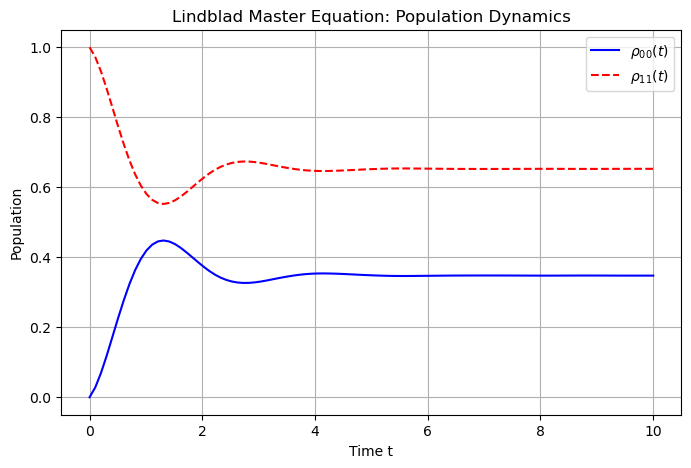

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
gamma_t = 1.0  # Dissipation rate
Nb = 0.2  # Mean bath occupation
Omega = 1.0  # Rabi frequency
Delta = 0.0  # Detuning

# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Hamiltonian H
H = (Omega / 2) * sigma_z + Omega * sigma_x

# Define the Lindbladian RHS with counting field chi
def lindblad_rhs(t, rho_flat):
    """Compute d(rho)/dt for the tilted master equation."""
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # Hamiltonian part
    commutator = -1j * (H @ rho - rho @ H)

    # Dissipative terms
    L1 = np.sqrt(gamma_t * (Nb + 1)) * sigma_minus  # Emission process
    L2 = np.sqrt(gamma_t * Nb) * sigma_plus  # Absorption process

    # Tilted dissipators
    D1 = (L1 @ rho @ L1.conj().T) - 0.5 * (L1.conj().T @ L1 @ rho + rho @ L1.conj().T @ L1)
    D2 = (L2 @ rho @ L2.conj().T) - 0.5 * (L2.conj().T @ L2 @ rho + rho @ L2.conj().T @ L2)

    d_rho = commutator + D1 + D2

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])


# Initial density matrix
rho0 = np.array([[0, 0], [0, 1]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])  # Flatten for solve_ivp

# Time range
t_span = (0, 10)
t_eval = np.linspace(*t_span, 100)

sol = solve_ivp(lindblad_rhs, t_span, rho0_flat, t_eval=t_eval, vectorized=True)

# Reconstruct the density matrix at each time step
rho_solutions = (sol.y[:4].T + 1j * sol.y[4:].T).reshape(-1, 2, 2)

plt.figure(figsize=(8, 5))
plt.plot(sol.t, rho_solutions[:, 0, 0].real, label=r"$\rho_{00}(t)$", color="blue")
plt.plot(sol.t, rho_solutions[:, 1, 1].real, label=r"$\rho_{11}(t)$", color="red", linestyle="dashed")
plt.xlabel("Time t")
plt.ylabel("Population")
plt.legend()
plt.title("Lindblad Master Equation: Population Dynamics")
plt.grid()
plt.show()

### For the Jaynes-Cummings model,

$$
\frac{d}{dt} \rho_S(t) = - \frac{i}{2} S(t) [\sigma^+ \sigma^-, \rho_S] + \Theta(t) \left( \sigma^- \rho_S \sigma^+ - \frac{1}{2} \{ \sigma^+ \sigma^-, \rho_S \} \right)
$$

where

$$
\Theta(t) = -2 Re\left( \frac{\dot{c}(t)}{c(t)} \right), \quad S(t) = -2 Im\left( \frac{\dot{c}(t)}{c(t)} \right).
$$
$$
c(t) = e^{-\frac{\chi t}{2}} \left( \cosh \frac{d t}{2} + \frac{\chi}{d} \sinh \frac{d t}{2} \right)
$$
$$
d = \sqrt{\chi^2 - 2 \Theta_0 \chi}
$$

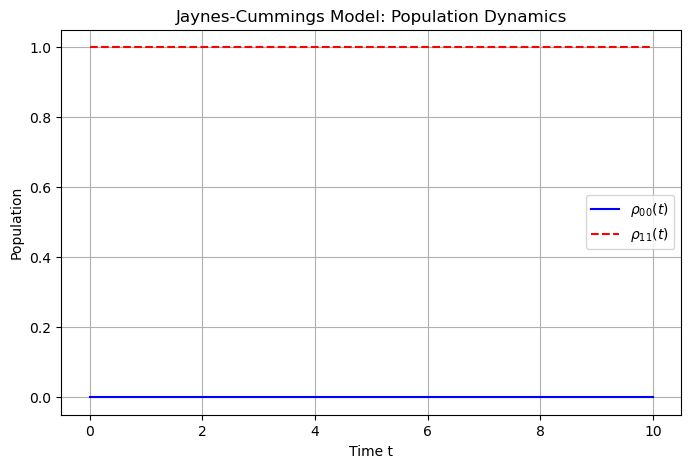

In [6]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
chi = 1
Theta0 = 2

# Define the correlation function c(t)
def c(t):
    delta = chi**2 - 2 * Theta0 * chi

    if delta > 0:
        d = np.sqrt(delta)
        return np.exp(-chi * t / 2) * (np.cosh(d * t / 2) + (chi / d) * np.sinh(d * t / 2))

    elif delta == 0:
        return np.exp(-chi * t / 2) * (1 + (chi * t) / 2)

    else:
        d = np.sqrt(-delta)
        return np.exp(-chi * t / 2) * (np.cos(d * t / 2) + (chi / d) * np.sin(d * t / 2))

def Theta(t, dt=1e-4):
    c_t = c(t)
    c_dot = (c(t + dt) - c_t) / dt
    return -2 * np.real(c_dot / c_t)

def S(t, dt=1e-4):
    c_t = c(t)
    c_dot = (c(t + dt) - c_t) / dt
    return -2 * np.imag(c_dot / c_t)


# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Define the Lindblad master equation
def lindblad_rhs(t, rho_flat):
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # The commutator term
    commutator = -1j* 0.5 * S(t) * (sigma_z @ rho - rho @ sigma_z)

    # The dissipator term
    dissipator = sigma_minus @ rho @ sigma_plus - 0.5 * (sigma_plus @ sigma_minus @ rho + rho @ sigma_plus @ sigma_minus)
    dissipator *= Theta(t)

    d_rho = commutator + dissipator

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])

# Initial state: pure |1⟩ state
rho0 = np.array([[0, 0], [0, 1]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])

# Time range
t_span = (0, 10)
t_eval = np.linspace(0, t_span[1], 100)

# Solve the master equation
sol = solve_ivp(lindblad_rhs, t_span, rho0_flat, t_eval=t_eval, vectorized=True)

# Reconstruct the density matrix evolution
rho_solutions = (sol.y[:4].T + 1j * sol.y[4:].T).reshape(-1, 2, 2)

# Plot population dynamics
plt.figure(figsize=(8, 5))
plt.plot(sol.t, rho_solutions[:, 0, 0].real, label=r"$\rho_{00}(t)$", color="blue")
plt.plot(sol.t, rho_solutions[:, 1, 1].real, label=r"$\rho_{11}(t)$", color="red", linestyle="dashed")
plt.xlabel("Time t")
plt.ylabel("Population")
plt.legend()
plt.title("Jaynes-Cummings Model: Population Dynamics")
plt.grid()
plt.show()

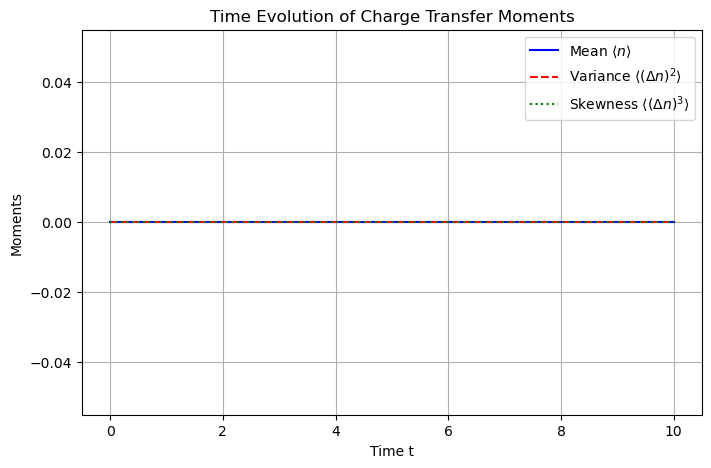

In [9]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
chi = 0.5
Theta0 = 1.0
chi_values = np.linspace(-np.pi, np.pi, 100)

def c(t):
    delta = chi**2 - 2 * Theta0 * chi

    if delta > 0:  # d is real
        d = np.sqrt(delta)
        return np.exp(-chi * t / 2) * (np.cosh(d * t / 2) + (chi / d) * np.sinh(d * t / 2))

    elif delta == 0:  # d = 0, need limit approach
        return np.exp(-chi * t / 2) * (1 + (chi * t) / 2)

    else:  # d is imaginary
        d = np.sqrt(-delta)
        return np.exp(-chi * t / 2) * (np.cos(d * t / 2) + (chi / d) * np.sin(d * t / 2))

# Compute Theta(t) and S(t)
def Theta(t, dt=1e-4):
    c_t = c(t)
    c_t_plus_dt = c(t + dt)
    c_dot = (c_t_plus_dt - c_t) / dt
    return -2 * np.real(c_dot / c_t)

def S(t, dt=1e-4):
    c_t = c(t)
    c_t_plus_dt = c(t + dt)
    c_dot = (c_t_plus_dt - c_t) / dt
    return -2 * chi * np.real(c_dot / c_t)

# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)

# Define the tilted Lindblad equation
def lindblad_rhs_chi(t, rho_flat, counting_field):
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # The commutator term
    commutator = -1j * S(t) * (sigma_z @ rho - rho @ sigma_z)

    # The modified dissipator with χ
    dissipator = np.exp(1j * counting_field) * (sigma_minus @ rho @ sigma_plus) - 0.5 * (sigma_plus @ sigma_minus @ rho + rho @ sigma_plus @ sigma_minus)
    dissipator *= Theta(t)

    d_rho = commutator + dissipator

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])

# Initial state: pure |1⟩ state
rho0 = np.array([[0, 0], [0, 1]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])

# Time range
t_final = 10
t_eval = np.linspace(0, t_final, 100)

# Compute P(chi, t) for different chi values at each time step
P_chi_t = np.zeros((len(t_eval), len(chi_values)), dtype=complex)

for j, chi_val in enumerate(chi_values):
    sol_chi = solve_ivp(
        lindblad_rhs_chi, (0, t_final), rho0_flat,
        t_eval=t_eval, args=(chi_val,), vectorized=True, method='RK45'
    )

    # Ensure correct time points match
    num_t_points = len(sol_chi.t)  # Actual number of computed time points
    rho_chi_solutions = (sol_chi.y[:4, :num_t_points].T + 1j * sol_chi.y[4:, :num_t_points].T).reshape(num_t_points, 2, 2)

    # Assign only the computed points
    P_chi_t[:num_t_points, j] = np.array([np.trace(rho) for rho in rho_chi_solutions])

# Compute the cumulant generating function S(chi, t) = log P(chi, t)
S_chi_t = np.log(np.maximum(P_chi_t, 1e-10))  # Avoid log(0) errors

# Compute moments by differentiation at each time step
dS_dchi = np.gradient(S_chi_t, 1j * chi_values, axis=1)  # First derivative -> Mean
d2S_dchi2 = np.gradient(dS_dchi, 1j * chi_values, axis=1)  # Second derivative -> Variance
d3S_dchi3 = np.gradient(d2S_dchi2, 1j * chi_values, axis=1)  # Third derivative -> Skewness

# Find index for chi = 0
chi_0_index = np.argmin(np.abs(chi_values))

# Extract time evolution of moments
mean_n_t = np.real(dS_dchi[:, chi_0_index])  # First moment at each time step
variance_n_t = np.real(d2S_dchi2[:, chi_0_index])  # Second moment
skewness_n_t = np.real(d3S_dchi3[:, chi_0_index])  # Third moment

# Plot time evolution of moments
plt.figure(figsize=(8, 5))
plt.plot(t_eval, mean_n_t, label=r"Mean $\langle n \rangle$", color="blue")
plt.plot(t_eval, variance_n_t, label=r"Variance $\langle (\Delta n)^2 \rangle$", color="red", linestyle="dashed")
plt.plot(t_eval, skewness_n_t, label=r"Skewness $\langle (\Delta n)^3 \rangle$", color="green", linestyle="dotted")
plt.xlabel("Time t")
plt.ylabel("Moments")
plt.legend()
plt.title("Time Evolution of Charge Transfer Moments")
plt.grid()
plt.show()

### In the above plots the initial state is in $|1 \rangle$. If the initial state chosen to be $|0 \rangle$ then,

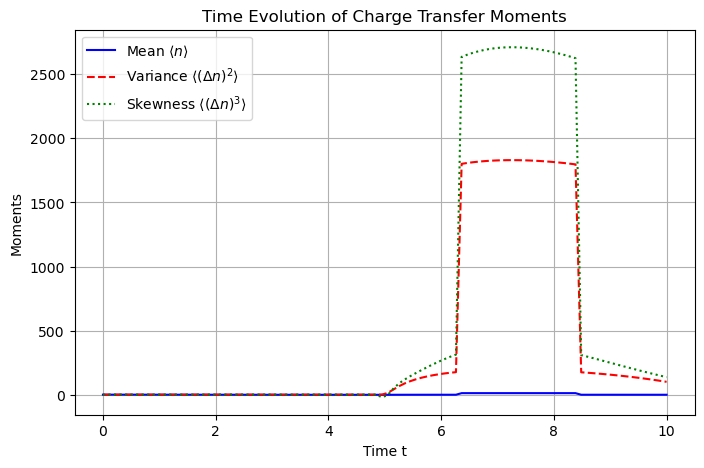

In [26]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
chi = 0.5
Theta0 = 1.0
chi_values = np.linspace(-np.pi, np.pi, 100)

def c(t):
    delta = chi**2 - 2 * Theta0 * chi

    if delta > 0:  # d is real
        d = np.sqrt(delta)
        return np.exp(-chi * t / 2) * (np.cosh(d * t / 2) + (chi / d) * np.sinh(d * t / 2))

    elif delta == 0:  # d = 0, need limit approach
        return np.exp(-chi * t / 2) * (1 + (chi * t) / 2)

    else:  # d is imaginary
        d = np.sqrt(-delta)
        return np.exp(-chi * t / 2) * (np.cos(d * t / 2) + (chi / d) * np.sin(d * t / 2))

# Compute Theta(t) and S(t)
def Theta(t, dt=1e-4):
    c_t = c(t)
    c_t_plus_dt = c(t + dt)
    c_dot = (c_t_plus_dt - c_t) / dt
    return -2 * np.real(c_dot / c_t)

def S(t, dt=1e-4):
    c_t = c(t)
    c_t_plus_dt = c(t + dt)
    c_dot = (c_t_plus_dt - c_t) / dt
    return -2 * chi * np.real(c_dot / c_t)

# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)

# Define the tilted Lindblad equation
def lindblad_rhs_chi(t, rho_flat, counting_field):
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # The commutator term
    commutator = -1j * S(t) * (sigma_plus @ sigma_minus @ rho - rho @ sigma_plus @ sigma_minus)

    # The modified dissipator with χ
    dissipator = np.exp(-1j * counting_field) * (sigma_minus @ rho @ sigma_plus) - 0.5 * (sigma_plus @ sigma_minus @ rho + rho @ sigma_plus @ sigma_minus)
    dissipator *= Theta(t)

    d_rho = commutator + dissipator

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])

# Initial state: pure |0⟩ state
rho0 = np.array([[1, 0], [0, 0]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])

# Time range
t_final = 10
t_eval = np.linspace(0, t_final, 100)

# Compute P(chi, t) for different chi values at each time step
P_chi_t = np.zeros((len(t_eval), len(chi_values)), dtype=complex)

for j, chi_val in enumerate(chi_values):
    sol_chi = solve_ivp(
        lindblad_rhs_chi, (0, t_final), rho0_flat,
        t_eval=t_eval, args=(chi_val,), vectorized=True, method='RK45'
    )

    # Ensure correct time points match
    num_t_points = len(sol_chi.t)  # Actual number of computed time points
    rho_chi_solutions = (sol_chi.y[:4, :num_t_points].T + 1j * sol_chi.y[4:, :num_t_points].T).reshape(num_t_points, 2, 2)

    # Assign only the computed points
    P_chi_t[:num_t_points, j] = np.array([np.trace(rho) for rho in rho_chi_solutions])

# Compute the cumulant generating function S(chi, t) = log P(chi, t)
S_chi_t = np.log(np.maximum(P_chi_t, 1e-10))  # Avoid log(0) errors

# Compute moments by differentiation at each time step
dS_dchi = np.gradient(S_chi_t, 1j * chi_values, axis=1)  # First derivative -> Mean
d2S_dchi2 = np.gradient(dS_dchi, 1j * chi_values, axis=1)  # Second derivative -> Variance
d3S_dchi3 = np.gradient(d2S_dchi2, 1j * chi_values, axis=1)  # Third derivative -> Skewness

# Find index for chi = 0
chi_0_index = np.argmin(np.abs(chi_values))

# Extract time evolution of moments
mean_n_t = np.real(dS_dchi[:, chi_0_index])  # First moment at each time step
variance_n_t = np.real(d2S_dchi2[:, chi_0_index])  # Second moment
skewness_n_t = np.real(d3S_dchi3[:, chi_0_index])  # Third moment

# Plot time evolution of moments
plt.figure(figsize=(8, 5))
plt.plot(t_eval, mean_n_t, label=r"Mean $\langle n \rangle$", color="blue")
plt.plot(t_eval, variance_n_t, label=r"Variance $\langle (\Delta n)^2 \rangle$", color="red", linestyle="dashed")
plt.plot(t_eval, skewness_n_t, label=r"Skewness $\langle (\Delta n)^3 \rangle$", color="green", linestyle="dotted")
plt.xlabel("Time t")
plt.ylabel("Moments")
plt.legend()
plt.title("Time Evolution of Charge Transfer Moments")
plt.grid()
plt.show()

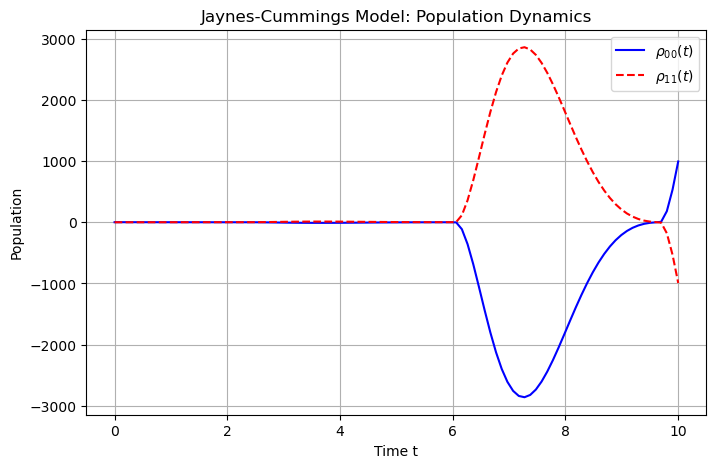

In [25]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# System parameters
chi = 1
Theta0 = 2

# Define the correlation function c(t)
def c(t):
    delta = chi**2 - 2 * Theta0 * chi

    if delta > 0:
        d = np.sqrt(delta)
        return np.exp(-chi * t / 2) * (np.cosh(d * t / 2) + (chi / d) * np.sinh(d * t / 2))

    elif delta == 0:
        return np.exp(-chi * t / 2) * (1 + (chi * t) / 2)

    else:
        d = np.sqrt(-delta)
        return np.exp(-chi * t / 2) * (np.cos(d * t / 2) + (chi / d) * np.sin(d * t / 2))

def Theta(t, dt=1e-4):
    c_t = c(t)
    c_dot = (c(t + dt) - c_t) / dt
    return -2 * np.real(c_dot / c_t)

def S(t, dt=1e-4):
    c_t = c(t)
    c_dot = (c(t + dt) - c_t) / dt
    return -2 * np.imag(c_dot / c_t)


# Pauli operators
sigma_plus = np.array([[0, 1], [0, 0]], dtype=complex)
sigma_minus = np.array([[0, 0], [1, 0]], dtype=complex)
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

# Define the Lindblad master equation
def lindblad_rhs(t, rho_flat):
    """Compute d(rho)/dt for the time-local master equation."""
    rho = rho_flat[:4].reshape((2, 2)) + 1j * rho_flat[4:].reshape((2, 2))

    # The commutator term
    commutator = -1j * S(t) * (sigma_plus @ sigma_minus @ rho - rho @ sigma_plus @ sigma_minus)

    # The dissipator term
    dissipator = sigma_minus @ rho @ sigma_plus - 0.5 * (sigma_plus @ sigma_minus @ rho + rho @ sigma_plus @ sigma_minus)
    dissipator *= Theta(t)

    d_rho = commutator + dissipator

    return np.concatenate([d_rho.real.flatten(), d_rho.imag.flatten()])

# Initial state: pure |0⟩ state
rho0 = np.array([[1, 0], [0, 0]], dtype=complex)
rho0_flat = np.concatenate([rho0.real.flatten(), rho0.imag.flatten()])

# Time range
t_span = (0, 10)
t_eval = np.linspace(0, t_span[1], 100)

# Solve the master equation
sol = solve_ivp(lindblad_rhs, t_span, rho0_flat, t_eval=t_eval, vectorized=True)

# Reconstruct the density matrix evolution
rho_solutions = (sol.y[:4].T + 1j * sol.y[4:].T).reshape(-1, 2, 2)

# Plot population dynamics
plt.figure(figsize=(8, 5))
plt.plot(sol.t, rho_solutions[:, 0, 0].real, label=r"$\rho_{00}(t)$", color="blue")
plt.plot(sol.t, rho_solutions[:, 1, 1].real, label=r"$\rho_{11}(t)$", color="red", linestyle="dashed")
plt.xlabel("Time t")
plt.ylabel("Population")
plt.legend()
plt.title("Jaynes-Cummings Model: Population Dynamics")
plt.grid()
plt.show()